In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from scipy import interpolate

from astropy import constants as const
from astropy import units as u

import extinction

from plotting_spectra import *

#plt.style.use('dark_background')

rc_params = {
    'lines.linewidth': 2,  # Set line width to 2 points
    'font.family': 'STIXGeneral',  # Set color cycle for axes
    'ytick.direction': 'in',  # Set figure size in inches
    'xtick.direction': 'in',  # Set default font family
}

plt.rcParams.update(rc_params)

In [2]:
# Here the lightcurves are loaded
lightcurves_alercextns = pd.read_pickle('./data/lightcurves/lcs_transients_20240517.pkl')
#lightcurves_alercextns

In [3]:
# Load all spectra info, metadata and data.
spectra_metadata = pd.read_csv('wiserep_spectra_metadata.csv', low_memory=False)
spectra_data     = pd.read_pickle('spectra_ALeRCE20240721_x_wisrep_20240622.pkl')

In [4]:
# List of supernova names with less than 5 spectra
list(spectra_data['snname'].value_counts()[spectra_data['snname'].value_counts() < 5].index)[0:5]

# usar el percentil 10 de los minimos
# Usar el percentil 90 de las maximos

#spectra_data.lambda_data_min.quantile(0.1)

['SN2021fl', 'SNLS-04D1aj', 'SN1996cc', 'SN2022abw', 'SN2020py']

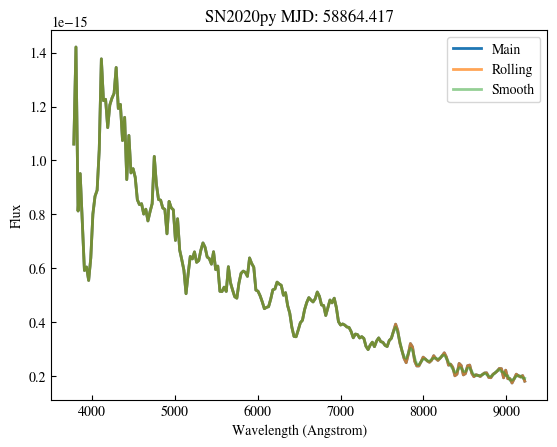

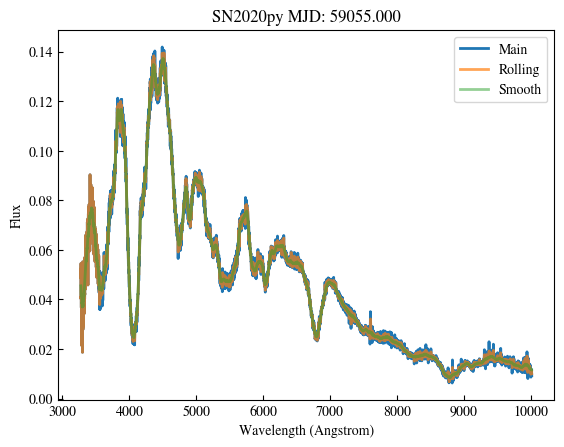

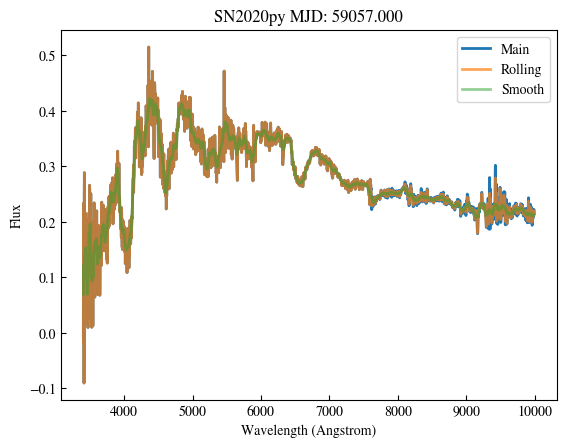

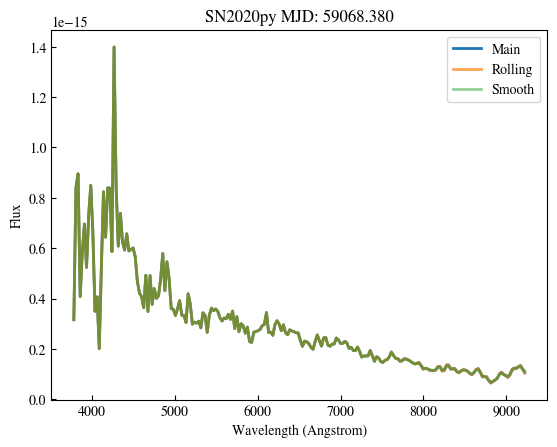

In [5]:
CSPEED = 3e5 # light_speed in km/s
dv = 200
dvsmooth = 2000
dlog10lambda = dv / CSPEED / np.log(10) * (24 * 3600) # pseudo seconds
dlog10lambdasmooth = dvsmooth / CSPEED / np.log(10) * 24 * 3600 # pseudo seconds

sn_name = 'SN2020py'
raw_spectra = pd.read_csv(f'./data/spectra_wiserep/{sn_name}.dat')
for group_name, group in raw_spectra.groupby('mjd'):
    fig, ax = plt.subplots()
    wave = group['lambda'].to_numpy()

    group["log10lambda"] = np.log10(wave)

    # fool pandas to make it think log10lambda is days
    group["log10lambda_idx"] = group["log10lambda"].apply(lambda x: pd.Timedelta(x, 'days'))
    group.set_index("log10lambda_idx", inplace=True)

    # sorting the index
    group = group.sort_index()

    # obtain the flux rolled of the log_lambda
    group["flux_log10lambda_rolling"] = group.flux_lambda.rolling(f'{int(dlog10lambda)}s', center=True).mean()
    #delta = (group.flux_log10lambda_rolling - group.flux_lambda.rolling(f'{int(dlog10lambdasmooth)}s', center=True).mean()).rolling(f'{int(dlog10lambdasmooth)}s', center=True).std()
    group["eflux_log10lambda_rolling"] = (group.flux_log10lambda_rolling - group.flux_lambda.rolling(f'{int(dlog10lambdasmooth)}s', center=True).mean()).rolling(f'{int(dlog10lambdasmooth)}s', center=True).std()

    flux = group['flux_lambda'].to_numpy()
    ax.plot(wave, flux, label='Main')
    ax.plot(wave, np.array(group.flux_lambda.rolling(f'{int(dlog10lambda)}s', center=True).mean()), alpha=0.7, label='Rolling')
    ax.plot(wave, np.array(group.flux_lambda.rolling(f'{int(dlog10lambdasmooth)}s', center=True).mean()), alpha=0.5, label='Smooth')
    #ax.plot(wave, group['eflux_log10lambda_rolling'].to_numpy())
    ax.set_title(f'{sn_name} MJD: {group_name:.3f}')
    ax.set_xlabel('Wavelength (Angstrom)')
    ax.set_ylabel('Flux')
    ax.legend()

In [8]:
spectrum = spectra_data[spectra_data.snname == np.random.choice(spectra_data.snname.unique())]
spectrum

,oid,snname,instrument,mjd,lambda_grid_min,lambda_grid_max,nlambda_grid,lambda_data_min,lambda_data_max,flux_lambda,e_flux_lambda
6759,14586,SN2020xzm,ESO-NTT_EFOSC2-NTT,59149.265654,3206.34,10915.01,1838,3650.047852,9245.227452,"[-3.841183e-18, 2.3819673e-17, 1.2082930000000...","[1.405784369501082e-17, 1.1594484634509109e-17..."


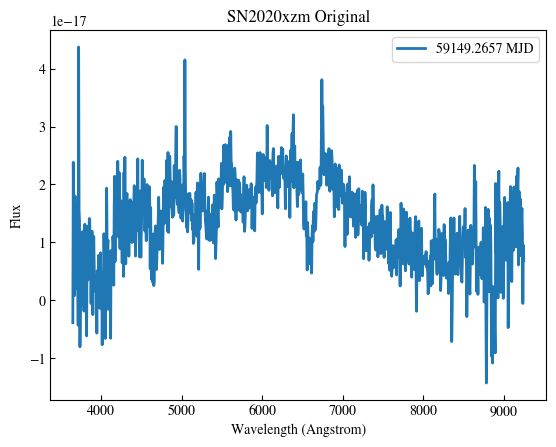

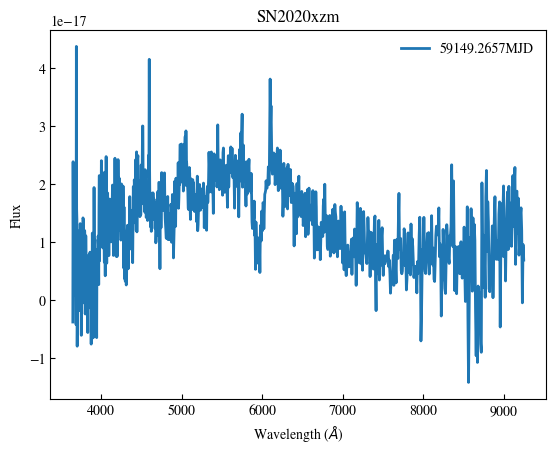

In [9]:
sn_name=spectrum.snname.unique()[0]
fig, ax = plt.subplots()
raw_spectra = pd.read_csv(f'./data/spectra_wiserep/{sn_name}.dat')
for group_name, group in raw_spectra.groupby('mjd'):
    ax.plot(group['lambda'].to_numpy(), group.flux_lambda.to_numpy(), label=f'{group_name:.4f} MJD')
ax.set_title(f'{sn_name} Original')# MJD: {group_name:.3f}')
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel('Flux')
ax.legend()
    
plot_spectra(spectrum, use_lambda_grid=False, sn_name=sn_name)

In [10]:
objective_ligtcurve = lightcurves_alercextns[lightcurves_alercextns.oid == 'ZTF21aaahtln']

In [11]:
wavelength_lsst = {'u':[3206.34, 4081.51], 'g':[3876.02, 5665.33], 'r':[5377.19, 7055.16],
                   'i':[6765.77, 8325.05], 'z':[8035.39, 9375.47], 'y':[9089.07, 10915.01]}

wavelength_ztf ={'g':[3676.00, 5613.82], 'r':[5497.60, 7394.40], 'i':[6870.97, 8964.61],}

ztf_sv_files  = [file for file in os.listdir('./data/') if 'Palomar' in file]
lsst_sv_files = [file for file in os.listdir('./data/') if 'LSST' in file]

ztf_sv_dict  = {file.split('.')[1]: np.loadtxt(fname=f'./data/{file}') for file in ztf_sv_files}
lsst_sv_dict = {file.split('.')[1]: np.loadtxt(fname=f'./data/{file}') for file in lsst_sv_files}

In [12]:
#grouped = raw_spectra.groupby('mjd').agg(list).reset_index()
# #grouped
# spectrum = raw_spectra.groupby('mjd').agg(list).reset_index()
# spectrum

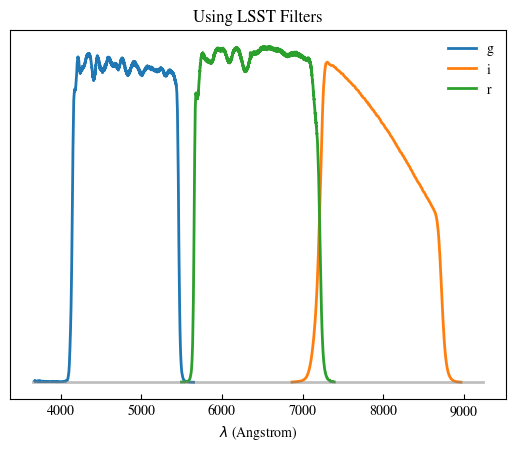

In [13]:
idx_spec = 0
fig, ax = plt.subplots()
#x_spectrum = np.array(spectrum.iloc[idx_spec]['lambda_'])

x_spectrum = np.logspace(np.log10(spectrum.iloc[idx_spec].lambda_data_min),np.log10(spectrum.iloc[idx_spec].lambda_data_max),len(spectrum.iloc[idx_spec].flux_lambda))
y_spectrum = np.array((spectrum.iloc[idx_spec]['flux_lambda'])) 

for band, sv in ztf_sv_dict.items():
    x, y = zip(*ztf_sv_dict[band])
    ax.plot(x,y,label=f'{band}')
ax.plot(x_spectrum, y_spectrum, alpha = 0.5, color='gray')
ax.set_xlabel(r'$\lambda$ (Angstrom)')
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_title('Using LSST Filters')
ax.legend(frameon=False)

plt.show()

In [14]:
def obtain_magnitude_flux(spectrum:pd.DataFrame,instrument:str) -> dict:

    CSPEED = 3e8 # m/s

    if instrument == 'ztf':
        tranmision_dict = ztf_sv_dict
    elif instrument ==  'lsst':
        tranmision_dict = lsst_sv_dict

    x_spectrum = np.linspace(spectrum.lambda_data_min,spectrum.lambda_data_max,len(spectrum.flux_lambda))
    #x_spectrum = np.array(spectrum['lambda'])
    y_spectrum = np.array(spectrum.flux_lambda)
    f = interpolate.interp1d(x_spectrum,y_spectrum, fill_value=np.nan, bounds_error=False)

    mags = {}   
    for band, s_wave in tranmision_dict.items():
        band, s_wave = band,s_wave
        wave, s_wave = zip(*tranmision_dict[band])
        wave, s_wave = np.array(wave), np.array(s_wave)

        #condition = np.where((min(wave) < x_spectrum) & (max(wave) > x_spectrum))
        #x = x_spectrum[condition]
        #y = y_spectrum[condition]
        
        flux_wave_new = f(wave)

        log_nu = -np.log(wave)                           # Obtaining log_nu in lambda termns
        f_nu   = (wave**2/(CSPEED*1e10)) * flux_wave_new # Obtaining f_nu in lambda termns
        s_nu   = s_wave 

        num = np.trapz(f_nu*s_nu, dx=log_nu[:-1])
        den = np.trapz(s_nu, dx=log_nu[:-1])
        #num_test = simple_integration(wave,f_nu*s_nu, log_nu)
        #den_test = simple_integration(wave,s_nu, log_nu)
        #m = -2.5 * np.log10(num_test/den_test) - 48.60
        m = -2.5 * np.log10(num/den) - 48.60
        mags.update({band:m})
    print(mags)
    return mags

{'g': 21.23267070885776, 'i': 20.70061083611281, 'r': 20.33175236213922}


NameError: name 'oid' is not defined

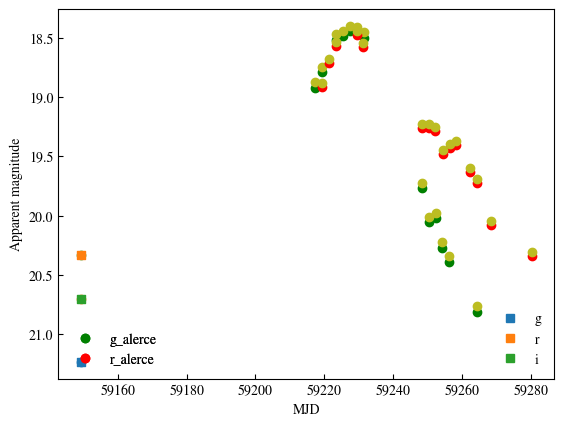

In [15]:
instrument = 'ztf'
if instrument == 'ztf':
    colors = ['C0','C1','C2']
    bands = ['g','r','i']
else:
    colors = ['C0','C1','C2','C3','C4','C5']
    bands = ['u','g','r','i','z','y']

wave = np.array([4746.48, 6366.38])

fig, ax = plt.subplots()
for _, row in spectrum.iterrows():
    for group_name, group in objective_ligtcurve.groupby('fid'):
        color = 'green' if group_name == 1 else 'red'
        extinction_correction = extinction.ccm89(wave, 0.0375, 3.1)[0] if group_name == 1 else extinction.ccm89(wave, 0.0375, 3.1)[1]
        ax.scatter(x=group.mjd, y=group.magpsf, color=color)
        ax.scatter(x=group.mjd, y=group.magpsf - extinction_correction, color='C8')
        
    # This calculate the magnitude of the spectrum based on
    # the integration of the flux
    
    try:
        magnitude_integrated = obtain_magnitude_flux(spectrum=row, instrument=instrument)
    except:
        continue
    for bandapass, magnitude in magnitude_integrated.items():
        ax.scatter(row.mjd,magnitude)
        if instrument == 'ztf':
            color = colors[0] if 'g' in bandapass else colors[1] if 'r' in bandapass else colors[2]
            #label = 
            ax.scatter(row.mjd,magnitude, marker='s',color = color)
        else: 
            color = colors[0] if 'u' in bandapass else colors[1] if 'g' in bandapass else colors[2] if 'r' in bandapass else colors[3] if 'i' in bandapass else colors[4] if 'z' in bandapass else colors[5]
            ax.scatter(row.mjd,magnitude, marker='s',color = color)
    
    handles = [mlines.Line2D([], [], c=color, marker='s',ls='') for color in colors]
    leg1 = ax.legend(handles, bands, loc='lower right',frameon=False)
    ax.add_artist(leg1)
    handles = [mlines.Line2D([], [], c=color, marker='o',ls='') for color in ['g', 'r']]
    leg2 = ax.legend(handles, ['g_alerce', 'r_alerce'], loc='lower left',frameon=False)
    ax.add_artist(leg2)

    ax.yaxis.set_inverted(True)
    ax.set_xlabel('MJD')
    ax.set_ylabel('Apparent magnitude')
    ax.set_title(f'Light Curve {oid}')

In [16]:
redshift = spectra_metadata[spectra_metadata['IAU name'] == 'SN 2021gd']['Redshift'].iloc[0]

{'g': 21.23267070885776, 'i': 20.70061083611281, 'r': 20.33175236213922}


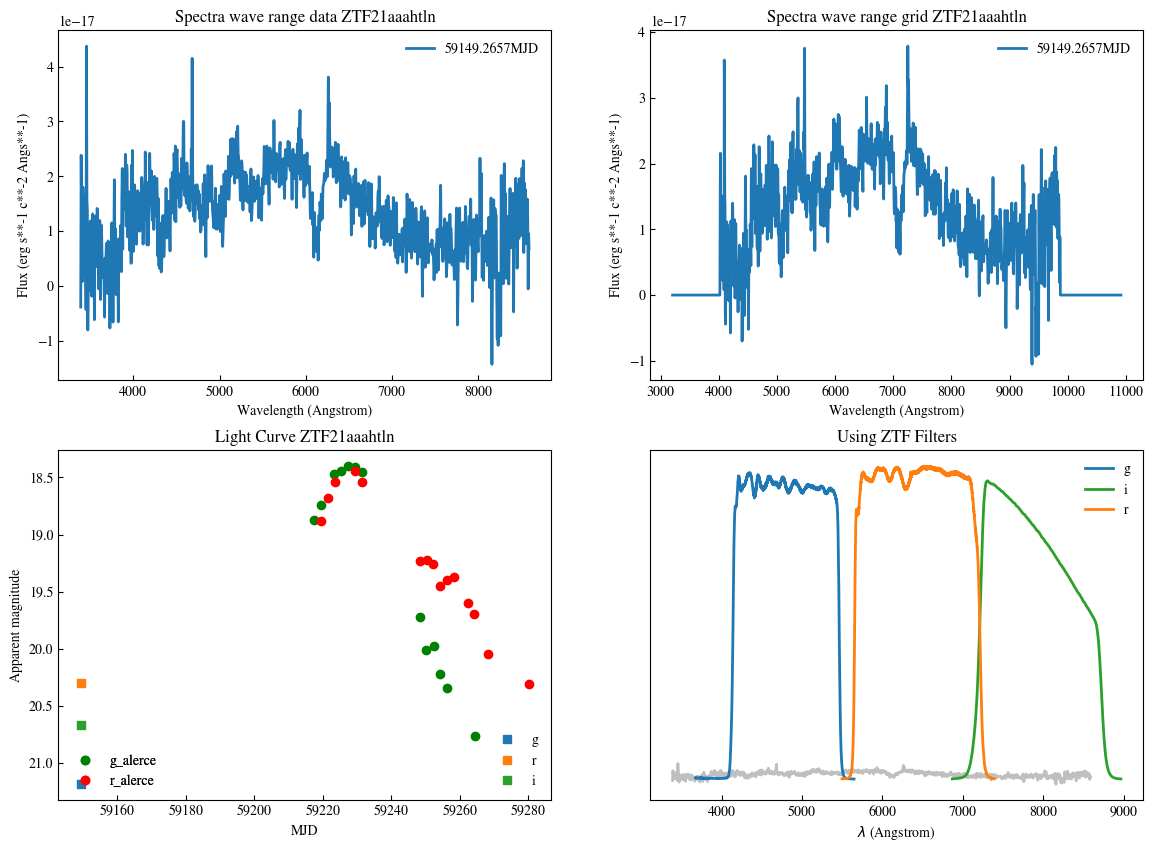

In [17]:
instrument = 'ztf'
if instrument == 'ztf':
    colors = ['C0','C1','C2']
    bands = ['g','r','i']
else:
    colors = ['C0','C1','C2','C3','C4','C5']
    bands = ['u','g','r','i','z','y']

wave = np.array([4746.48, 6366.38])

fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(nrows=2,ncols=2, figsize=(14, 10))
oid = 'ZTF21aaahtln'
for _, row in spectrum.iterrows():

    # This calculate the x-axis and y-axis of the spectrum
    x_spectrum = np.linspace(row.lambda_data_min,row.lambda_data_max, len(row.flux_lambda))
    x_spectrum = x_spectrum / (1+redshift)
    y_spectrum = np.array(row.flux_lambda)

    

    ax0.plot(x_spectrum, y_spectrum,label=f'{row.mjd:.4f}MJD')
    ax0.set_ylabel('Flux (erg s**-1 c**-2 Angs**-1)')
    ax0.set_xlabel('Wavelength (Angstrom)')
    #ax1.text(x=max(x_spectrum)-500,
    #                 y=max(y_spectrum*2),
    #                 s=f'{row.mjd:.4f}MJD')
    ax0.set_title(f'Spectra wave range data {oid}')
    ax0.legend(frameon=False)

    x_spectrum_grid = np.linspace(row.lambda_grid_min,row.lambda_grid_max, row.nlambda_grid)
    y_spectrum_grid = interpolate_flux(row)
    ax1.plot(x_spectrum_grid, y_spectrum_grid,label=f'{row.mjd:.4f}MJD')
    ax1.set_ylabel('Flux (erg s**-1 c**-2 Angs**-1)')
    ax1.set_xlabel('Wavelength (Angstrom)')
    ax1.set_title(f'Spectra wave range grid {oid}')
    ax1.legend(frameon=False)

    for group_name, group in objective_ligtcurve.groupby('fid'):
        color = 'green' if group_name == 1 else 'red'
        extinction_correction = extinction.ccm89(wave, 0.0375, 3.1)[0] if group_name == 1 else extinction.ccm89(wave, 0.0375, 3.1)[1]
        ax2.scatter(x=group.mjd, y=group.magpsf - extinction_correction, color=color)
        
    # This calculate the magnitude of the spectrum based on
    # the integration of the flux
    
    magnitude_integrated = obtain_magnitude_flux(spectrum=row, instrument=instrument)
    for bandapass, magnitude in magnitude_integrated.items():
        if instrument == 'ztf':
            color = colors[0] if 'g' in bandapass else colors[1] if 'r' in bandapass else colors[2]
            extinction_correction = extinction.ccm89(wave, 0.0375, 3.1)[0] if 'g' in bandapass else extinction.ccm89(wave, 0.0375, 3.1)[1]
            #label = 
            ax2.scatter(row.mjd,magnitude - extinction_correction, marker='s',color = color)
        else: 
            color = colors[0] if 'u' in bandapass else colors[1] if 'g' in bandapass else colors[2] if 'r' in bandapass else colors[3] if 'i' in bandapass else colors[4] if 'z' in bandapass else colors[5]
            ax2.scatter(row.mjd,magnitude, marker='s',color = color)
    
    handles = [mlines.Line2D([], [], c=color, marker='s',ls='') for color in colors]
    leg1 = ax2.legend(handles, bands, loc='lower right',frameon=False)
    ax2.add_artist(leg1)
    handles = [mlines.Line2D([], [], c=color, marker='o',ls='') for color in ['g', 'r']]
    leg2 = ax2.legend(handles, ['g_alerce', 'r_alerce'], loc='lower left',frameon=False)
    ax2.add_artist(leg2)

    ax2.yaxis.set_inverted(True)
    ax2.set_xlabel('MJD')
    ax2.set_ylabel('Apparent magnitude')
    ax2.set_title(f'Light Curve {oid}')

    ax3.plot(x_spectrum, y_spectrum *1e15, alpha = 0.5, color='gray')
for band, sv in ztf_sv_dict.items():
    color = 'C0' if band == 'g' else 'C1' if band == 'r' else 'C2'
    x, y = zip(*ztf_sv_dict[band])
    ax3.plot(x,y,label=f'{band}', color=color)
ax3.set_xlabel(r'$\lambda$ (Angstrom)')
ax3.set_yticklabels([])
ax3.set_yticks([])
ax3.set_title('Using ZTF Filters')
ax3.legend(frameon=False)
plt.show()

In [ ]:
def obtain_lambda_grid(df:pd.Series) -> list[float]:

    lambda_grid = np.logspace(start=np.log10(df.lambda_grid_min),
                stop=np.log10(df.lambda_grid_max),
                num=df.nlambda_grid)

    return lambda_grid

In [ ]:
def interpolate_flux(df:pd.Series) -> list[float]:
    
    lambda_grid = obtain_lambda_grid(df)
    
    flux = np.array(df.flux_lambda)
    lambda_data = np.logspace(start=np.log10(df.lambda_data_min),
                stop=np.log10(df.lambda_data_max),
                num=len(flux))

    f = interpolate.interp1d(lambda_data, flux, fill_value=np.nan, bounds_error=False)
    flux_new = f(lambda_grid)

    return flux_new 


In [ ]:
def simpler_intergrate(x:list[float],y:list[float]) -> float:
    
    y = np.nan_to_num(y, nan=0.0)
    
    integral = 0
    
    LSUN = const.L_sun

    for i in range(1,len(x)):
        delta_x = x[i] - x[i-1]
        integral += y[i-1] * delta_x

    return integral

In [ ]:
def obtain_luminosity_condition(df:pd.Series, instrument:str):

    lambda_grid = obtain_lambda_grid(df)
    flux = interpolate_flux(df)

    luminosity_list = []

    if instrument == 'ztf':
        bandpasses = ['g','r','i']

        for bandpass in bandpasses:
            condition = np.where((wavelength_ztf[bandpass][0] < lambda_grid) & (wavelength_ztf[bandpass][1] > lambda_grid))
            x = lambda_grid[condition]
            y = flux[condition]
            #y = convert_flux2mag(y)
            luminosity = simpler_intergrate(x, y)
            luminosity_list.append(luminosity)

        return dict(zip(bandpasses, luminosity_list))
            

    elif instrument == 'lsst':
        bandpasses = ['u','g','r','i','z','y']

        for bandpass in bandpasses:
            condition = np.where((wavelength_lsst[bandpass][0] < lambda_grid) & (wavelength_lsst[bandpass][1] > lambda_grid))
            x = lambda_grid[condition]
            y = flux[condition]
            #y = convert_flux2mag(y)
            luminosity = simpler_intergrate(x, y)
            luminosity_list.append(luminosity)

        return dict(zip(bandpasses, luminosity_list))

    else:
        return print('There is not that instrument in list')

In [ ]:


# Av = 0.0375

Calcualte the magnitud

https://articles.adsabs.harvard.edu/pdf/1996AJ....111.1748F

In [ ]:
def simple_integration(x:list[float],y:list[float],delta_x:list[float]) -> float:
    y = np.nan_to_num(y, nan=0.0)

    if delta_x == None:
        delta_x = x[i] 

    integral = 0
    for i in range(len(delta_x)-1):
        integral += (y[i] + y[i+1]) * delta_x[i] / 2.0
    return integral